# Final project Caltech256
-- Network used VGG16

- **Pretrained VGG model (using weights of imageNet)**

Student Name/ID : Aloukik aditya(115290) , Sarthak Rawat(1101124)
 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,concatenate,Activation
import numpy as np
from PIL import Image
from os import listdir
import sys
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from sklearn.preprocessing import OneHotEncoder
import timeit
import gc
import random
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import LearningRateScheduler
from time import time
from keras.preprocessing.image import ImageDataGenerator

print("Setup Done..")

Setup Done..


Using TensorFlow backend.


## Loading test and train data 
- we have split the data into 30 images of each category for Training 
- And the rest for testing

In [2]:
path = './256_ObjectCategories/'
random.seed(28)
img_size = 224
test_dict = {}
train_dict = {}

train_imgs = []
test_imgs = []
train_labels = []
test_labels = []

ctr=0

start = timeit.default_timer()
categories = listdir(path)
for category in categories:
    image_files_list = glob.glob(path+category+ '/*.jpg')
    train_list = random.sample(image_files_list, k=30)
    test_list = [x for x in image_files_list if x not in train_list]
    test_dict[category] = test_list
    train_dict[category] = train_list

    
for key in test_dict:
    for img_name in test_dict[key]:
        file =  img_name
        test_imgs.append(np.array(image.load_img(file, target_size=(img_size, img_size))))
        test_labels.append(key)

        
for key in train_dict:
    for img_name in train_dict[key]:
        file =  img_name
        train_imgs.append(np.array(image.load_img(file, target_size=(img_size, img_size))))
        train_labels.append(key)


stop = timeit.default_timer()
print("Loading dataset Done")
print('Time taken to load data : ', stop - start)              
test_imgs = np.array(test_imgs)
train_imgs = np.array(train_imgs)
test_labels = np.array(test_labels)
train_labels = np.array(train_labels)

Loading dataset Done
Time taken to load data :  269.1891710340001


## Checking data shape and size
- We can see Train shape is of 7710 images (257*30)
- And rest for testing

In [3]:
gc.collect()
print("Shape of train data: ",train_imgs.shape)
print("Shape of test data: ",test_imgs.shape)
print("Shape of train labels: ",train_labels.shape)
print("Shape of test labels: ",test_labels.shape)
print("Total instances: ",train_labels.shape[0]+test_labels.shape[0])

Shape of train data:  (7710, 224, 224, 3)
Shape of test data:  (22897, 224, 224, 3)
Shape of train labels:  (7710,)
Shape of test labels:  (22897,)
Total instances:  30607


## Plotting some random images

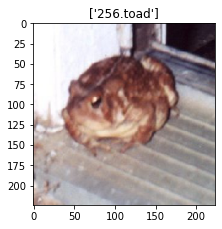

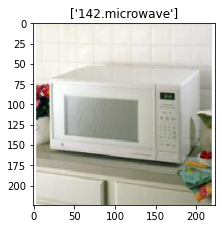

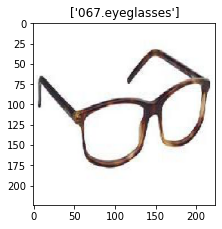

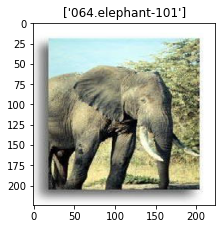

In [4]:

val_index = []
random.seed(22)
for i in range(4):
    value = random.randint(0,3582)
    val_index.append(value)
    plt.figure( figsize=(15, 15))
    plt.subplot(1, 4, i+1)
    plt.title([train_labels[value]])
    plt.imshow(train_imgs[value])

# plt.tight_layout()
plt.show()

# Preprocess image using VGG function image

In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input 
start = timeit.default_timer()
train_imgs = preprocess_input(train_imgs)
test_imgs = preprocess_input(test_imgs)
stop = timeit.default_timer()
print('Time taken to preprocess/normalize data : ', stop - start)
gc.collect()

Time taken to preprocess/normalize data :  14.749757037999984


9803

In [6]:
#check shape of  image
#number of train images are now doubled due to image augmentation(we have only used flip image for augmentation)
print(train_imgs.shape)
test_imgs.shape

(7710, 224, 224, 3)


(22897, 224, 224, 3)

## Applying one hot encoding on our labels

In [7]:
onehot_encoder = OneHotEncoder(sparse=False)

train_labels = train_labels.reshape(-1,1)
test_labels = test_labels.reshape(-1,1)

train_labels = onehot_encoder.fit_transform(train_labels)
test_labels = onehot_encoder.transform(test_labels)

In [8]:
# test_labels1 = onehot_encoder.inverse_transform(test_labels)

In [9]:
print("Shape of train labels: ",train_labels.shape)
print("Shape of test labels: ",test_labels.shape)

Shape of train labels:  (7710, 257)
Shape of test labels:  (22897, 257)


In [10]:
# Function to free up keras memory

from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow 

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    

## Using model from keras--> VGG16
- we have used pretrained weights for imagenet and removed the top fully connected layers.

In [11]:
#define variable learning rates

def learning_rate_schedule(epoch):
    if epoch <= 6:
        return 1e-5 # 0.00001
    elif epoch <= 8:
        return 1e-5
    elif epoch <= 15:
        return 1e-6
    else:
        return 1e-7
    return LR

In [12]:
#Initilize vgg net
vgg_net = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))

#Define our model 
x = vgg_net.get_layer('fc2').output
x = Dense(900, activity_regularizer=l1(0.001), name='my_fc3')(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(257, activation='softmax', name='predictions')(x)
model_updated = Model(inputs=vgg_net.input, outputs=x)


## save our model weights
model_updated.save_weights('CALTECH256_VGG16_model_updated_initial.h5')
print("Model_Updated saved")

history_fc_list = []
history_full_list = []


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model_Updated saved


## Using Keras image generator for image augmentation

In [13]:
EPOCHS = 2
BATCH_SIZE = 128

train_generator = ImageDataGenerator(
                                        rotation_range = 20,
                                             horizontal_flip = True,
                                             zoom_range = .1 ,\
                                     fill_mode='nearest').flow(train_imgs, train_labels, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(test_imgs, test_labels, batch_size=BATCH_SIZE)

validation_steps = test_imgs.shape[0]//BATCH_SIZE

steps_per_epoch = train_imgs.shape[0]//BATCH_SIZE

## Run 1

In [14]:

i=0
#Initilize vgg net
vgg_net = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))

#Define our model 
x = vgg_net.get_layer('fc2').output
x = Dense(900, activity_regularizer=l1(0.001), name='my_fc3')(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(257, activation='softmax', name='predictions')(x)
model_updated = Model(inputs=vgg_net.input, outputs=x)

gc.collect()


model_updated.load_weights('CALTECH256_VGG16_model_updated_initial.h5')

print('------------------------New run started---------------------------------')
print('Initial model weights loaded , Started training run number ', i+1)
print('------------------------------------------------------------------------')

# Make the last Fully connected layers trainable and freezing the rest of VGG model
for layer in model_updated.layers:
    layer.trainable = False
for layer in model_updated.layers[-4:]:
    layer.trainable = True

tensorboard = TensorBoard(log_dir="logs\{}".format('CALTECH256\FC_Layer'+str(i)))

model_updated.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])


print('--------------------------Starting Fully connected layer training------------------------------------')

# history_fc = model_updated.fit(train_imgs, train_labels, batch_size=128,\
# shuffle=True, epochs=2, validation_data=\
#                     (test_imgs, test_labels),callbacks =[tensorboard])

history_fc = model_updated.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[tensorboard])


gc.collect()
##Unfreeze weights ------ Now full model will be trained
for layer in model_updated.layers:
    layer.trainable = True


no_epochs = 20
tensorboard = TensorBoard(log_dir="logs\{}".format('CALTECH256\FULL_Model'+str(i)))

opt2 = optimizers.Adam(lr=0.00001)

### Variable learning rate -----------------------
lrate = LearningRateScheduler(learning_rate_schedule)
callbacks_list = [lrate,tensorboard]




model_updated.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])


print('--------------------------Starting Full model training -->after unfreez------------------------------------')

## Training full model 
# history = model_updated.fit(train_imgs, train_labels, batch_size=128,\
# shuffle=True, epochs=no_epochs, validation_data=\
#                     (test_imgs, test_labels),callbacks =callbacks_list)
history = model_updated.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=no_epochs, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[tensorboard])



## Timer for checking time taken
stop = timeit.default_timer()
print('Time taken for one run is : ', stop - start)

model_updated.save_weights('CALTECH256_VGG16_model_updated_fin.h5')
print("Model_Updated weights saved") 

## saving history for plots
history_fc_list.append(history_fc)
history_full_list.append(history)

------------------------New run started---------------------------------
Initial model weights loaded , Started training run number  1
------------------------------------------------------------------------
--------------------------Starting Fully connected layer training------------------------------------
Epoch 1/2
60/60 [==============================] - 129s 2s/step - loss: 6.6255 - acc: 0.0561 - val_loss: 4.9545 - val_acc: 0.3369
Epoch 2/2
60/60 [==============================] - 126s 2s/step - loss: 4.5810 - acc: 0.2975 - val_loss: 3.4254 - val_acc: 0.5646
--------------------------Starting Full model training -->after unfreez------------------------------------
Epoch 1/20
60/60 [==============================] - 128s 2s/step - loss: 3.4642 - acc: 0.4774 - val_loss: 2.8850 - val_acc: 0.6373
Epoch 2/20
60/60 [==============================] - 126s 2s/step - loss: 2.7851 - acc: 0.6142 - val_loss: 2.5984 - val_acc: 0.6781
Epoch 3/20
60/60 [==============================] - 126s 2s/

## Run 2

In [15]:

i=1
#Initilize vgg net
vgg_net = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))

#Define our model 
x = vgg_net.get_layer('fc2').output
x = Dense(900, activity_regularizer=l1(0.001), name='my_fc3')(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(257, activation='softmax', name='predictions')(x)
model_updated = Model(inputs=vgg_net.input, outputs=x)

gc.collect()


model_updated.load_weights('CALTECH256_VGG16_model_updated_initial.h5')

print('------------------------New run started---------------------------------')
print('Initial model weights loaded , Started training run number ', i+1)
print('------------------------------------------------------------------------')

# Make the last Fully connected layers trainable and freezing the rest of VGG model
for layer in model_updated.layers:
    layer.trainable = False
for layer in model_updated.layers[-4:]:
    layer.trainable = True

tensorboard = TensorBoard(log_dir="logs\{}".format('CALTECH256\FC_Layer'+str(i)))

model_updated.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])


print('--------------------------Starting Fully connected layer training------------------------------------')

# history_fc = model_updated.fit(train_imgs, train_labels, batch_size=128,\
# shuffle=True, epochs=2, validation_data=\
#                     (test_imgs, test_labels),callbacks =[tensorboard])

history_fc = model_updated.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[tensorboard])


gc.collect()
##Unfreeze weights ------ Now full model will be trained
for layer in model_updated.layers:
    layer.trainable = True


no_epochs = 20
tensorboard = TensorBoard(log_dir="logs\{}".format('CALTECH256\FULL_Model'+str(i)))

opt2 = optimizers.Adam(lr=0.00001)

### Variable learning rate -----------------------
lrate = LearningRateScheduler(learning_rate_schedule)
callbacks_list = [lrate,tensorboard]




model_updated.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])


print('--------------------------Starting Full model training -->after unfreez------------------------------------')

## Training full model 
# history = model_updated.fit(train_imgs, train_labels, batch_size=128,\
# shuffle=True, epochs=no_epochs, validation_data=\
#                     (test_imgs, test_labels),callbacks =callbacks_list)
history = model_updated.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=no_epochs, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[tensorboard])



## Timer for checking time taken
stop = timeit.default_timer()
print('Time taken for one run is : ', stop - start)

model_updated.save_weights('CALTECH256_VGG16_model_updated_fin.h5')
print("Model_Updated weights saved") 

## saving history for plots
history_fc_list.append(history_fc)
history_full_list.append(history)

------------------------New run started---------------------------------
Initial model weights loaded , Started training run number  2
------------------------------------------------------------------------
--------------------------Starting Fully connected layer training------------------------------------
Epoch 1/2
60/60 [==============================] - 126s 2s/step - loss: 6.6130 - acc: 0.0590 - val_loss: 4.8997 - val_acc: 0.3495
Epoch 2/2
60/60 [==============================] - 124s 2s/step - loss: 4.5632 - acc: 0.2997 - val_loss: 3.4300 - val_acc: 0.5593
--------------------------Starting Full model training -->after unfreez------------------------------------
Epoch 1/20
60/60 [==============================] - 127s 2s/step - loss: 3.4578 - acc: 0.4756 - val_loss: 2.8873 - val_acc: 0.6347
Epoch 2/20
60/60 [==============================] - 127s 2s/step - loss: 2.7814 - acc: 0.6128 - val_loss: 2.6062 - val_acc: 0.6792
Epoch 3/20
60/60 [==============================] - 126s 2s/

## Run 3

In [17]:
reset_keras()
i=2
#Initilize vgg net
vgg_net = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))

#Define our model 
x = vgg_net.get_layer('fc2').output
x = Dense(900, activity_regularizer=l1(0.001), name='my_fc3')(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(257, activation='softmax', name='predictions')(x)
model_updated = Model(inputs=vgg_net.input, outputs=x)

gc.collect()


model_updated.load_weights('CALTECH256_VGG16_model_updated_initial.h5')

print('------------------------New run started---------------------------------')
print('Initial model weights loaded , Started training run number ', i+1)
print('------------------------------------------------------------------------')

# Make the last Fully connected layers trainable and freezing the rest of VGG model
for layer in model_updated.layers:
    layer.trainable = False
for layer in model_updated.layers[-4:]:
    layer.trainable = True

tensorboard = TensorBoard(log_dir="logs\{}".format('CALTECH256\FC_Layer'+str(i)))

model_updated.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])


print('--------------------------Starting Fully connected layer training------------------------------------')

# history_fc = model_updated.fit(train_imgs, train_labels, batch_size=128,\
# shuffle=True, epochs=2, validation_data=\
#                     (test_imgs, test_labels),callbacks =[tensorboard])

history_fc = model_updated.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[tensorboard])


gc.collect()
##Unfreeze weights ------ Now full model will be trained
for layer in model_updated.layers:
    layer.trainable = True


no_epochs = 20
tensorboard = TensorBoard(log_dir="logs\{}".format('CALTECH256\FULL_Model'+str(i)))

opt2 = optimizers.Adam(lr=0.00001)

### Variable learning rate -----------------------
lrate = LearningRateScheduler(learning_rate_schedule)
callbacks_list = [lrate,tensorboard]




model_updated.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])


print('--------------------------Starting Full model training -->after unfreez------------------------------------')

## Training full model 
# history = model_updated.fit(train_imgs, train_labels, batch_size=128,\
# shuffle=True, epochs=no_epochs, validation_data=\
#                     (test_imgs, test_labels),callbacks =callbacks_list)
history = model_updated.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=no_epochs, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[tensorboard])



## Timer for checking time taken
stop = timeit.default_timer()
print('Time taken for one run is : ', stop - start)

model_updated.save_weights('CALTECH256_VGG16_model_updated_fin.h5')
print("Model_Updated weights saved") 

## saving history for plots
history_fc_list.append(history_fc)
history_full_list.append(history)

40
------------------------New run started---------------------------------
Initial model weights loaded , Started training run number  3
------------------------------------------------------------------------
--------------------------Starting Fully connected layer training------------------------------------
Epoch 1/2
60/60 [==============================] - 131s 2s/step - loss: 6.5894 - acc: 0.0588 - val_loss: 4.8751 - val_acc: 0.3612
Epoch 2/2
60/60 [==============================] - 127s 2s/step - loss: 4.5449 - acc: 0.3031 - val_loss: 3.3969 - val_acc: 0.5654
--------------------------Starting Full model training -->after unfreez------------------------------------
Epoch 1/20
60/60 [==============================] - 129s 2s/step - loss: 3.4437 - acc: 0.4846 - val_loss: 2.8832 - val_acc: 0.6360
Epoch 2/20
60/60 [==============================] - 127s 2s/step - loss: 2.8075 - acc: 0.6056 - val_loss: 2.6196 - val_acc: 0.6752
Epoch 3/20
60/60 [==============================] - 128s 

## Tensorboard logs have been save to logs folder
- where "*\FC_Layer" folder means logs where we train only our FC layers
- where "*\FULL_Model" folder means logs where we train all layers in our model

## Plotting the graphs of testing accuracy 
- Test accuracy
- Plotted for only FC_layer training
- Plotted for full model training


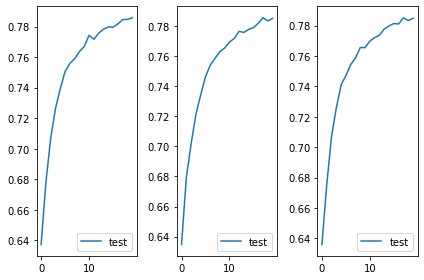

Average testing accuracy: 0.7853317856788635


In [18]:
plt.subplot(1, 3, 1)
plt.plot(history_full_list[0].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history_full_list[1].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 3)
plt.plot(history_full_list[2].history['val_acc'])
plt.legend(['test'], loc='lower right')
plt.tight_layout() 

plt.show()

avg_train_acc = 0
avg_test_acc = 0
final_train_loss = []
final_test_loss = []

for his in history_full_list:
    final_train_loss.append(his.history['loss'][-1])
    final_test_loss.append(his.history['val_loss'][-1])
    avg_train_acc = avg_train_acc + his.history['acc'][-1]
    avg_test_acc = avg_test_acc + his.history['val_acc'][-1]

avg_train_acc = avg_train_acc/len(history_fc_list)
avg_test_acc = avg_test_acc/len(history_fc_list)


print("Average testing accuracy: {}".format(avg_test_acc))

## Train acc vs Test acc

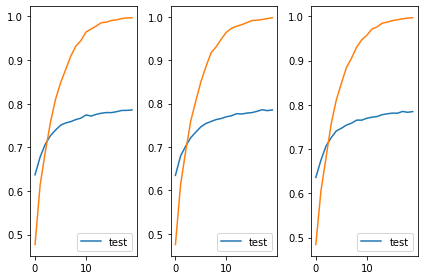

Average train accuracy: 0.9972302714983622


In [19]:
plt.subplot(1, 3, 1)
plt.plot(history_full_list[0].history['val_acc'])
plt.plot(history_full_list[0].history['acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history_full_list[1].history['val_acc'])
plt.plot(history_full_list[1].history['acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 3)
plt.plot(history_full_list[2].history['val_acc'])
plt.plot(history_full_list[2].history['acc'])
plt.legend(['test'], loc='lower right')
plt.tight_layout() 

plt.show()
print("Average train accuracy: {}".format(avg_train_acc))

## FC layers test and train accuracy

- Fc layers training accuracy
- graphs look linear since we have only 2 epoch
- accuracy graph of full model training is plotted above

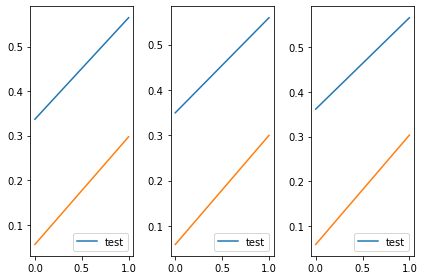

In [20]:
plt.subplot(1, 3, 1)
plt.plot(history_fc_list[0].history['val_acc'])
plt.plot(history_fc_list[0].history['acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history_fc_list[1].history['val_acc'])
plt.plot(history_fc_list[1].history['acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 3)
plt.plot(history_fc_list[2].history['val_acc'])
plt.plot(history_fc_list[2].history['acc'])
plt.legend(['test'], loc='lower right')
plt.tight_layout() 

plt.show()

# Final model average accuracy on test set

In [21]:
print("Average Model Train accuracy is  : ",avg_test_acc*100,"%")

Average Model Train accuracy is  :  78.53317856788635 %
